In [10]:
# The following script implement the DBSCAN model according to the Youtube video:
# StatQuest with Josh Starmer - Clustering with DBSCAN, Clearly Explained!!! link: https://www.youtube.com/watch?v=RDZUdRSDOok&ab_channel=StatQuestwithJoshStarmer
# DBSCAN is an unsupervised clustering algorithm.

In [1]:
import numpy as np
import matplotlib_inline
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns

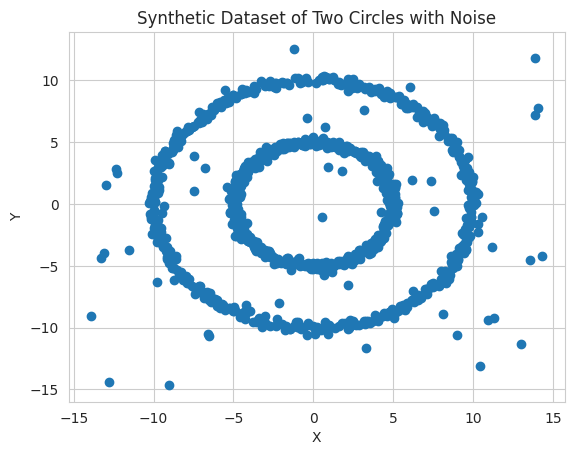

In [2]:
# Define parameters for the circles and noise
inner_radius = 5
outer_radius = 10
num_points_per_circle = 500
num_random_points = 50
noise_std_dev = 0.2

# Generate points for the inner circle
theta_inner = np.linspace(0, 2*np.pi, num_points_per_circle)
inner_circle_x = inner_radius * np.cos(theta_inner)
inner_circle_y = inner_radius * np.sin(theta_inner)

# Generate points for the outer circle
theta_outer = np.linspace(0, 2*np.pi, num_points_per_circle)
outer_circle_x = outer_radius * np.cos(theta_outer)
outer_circle_y = outer_radius * np.sin(theta_outer)

# Add noise to the points
inner_circle_x += np.random.normal(0, noise_std_dev, num_points_per_circle)
inner_circle_y += np.random.normal(0, noise_std_dev, num_points_per_circle)
outer_circle_x += np.random.normal(0, noise_std_dev, num_points_per_circle)
outer_circle_y += np.random.normal(0, noise_std_dev, num_points_per_circle)

x_random = np.random.uniform(-15, 15, size=(num_random_points,))
y_random = np.random.uniform(-15, 15, size=(num_random_points,))

# Combine the points from both circles
x = np.concatenate((inner_circle_x, outer_circle_x, x_random))
y = np.concatenate((inner_circle_y, outer_circle_y, y_random))

# Create a scatter plot of the dataset
plt.scatter(x, y)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Synthetic Dataset of Two Circles with Noise')
plt.show()

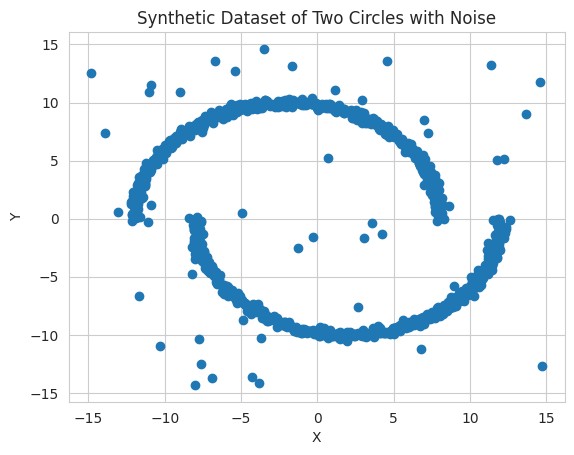

In [3]:
# Define parameters for the circles and noise
inner_radius = 5
outer_radius = 10
num_points_per_circle = 500
num_random_points = 50
noise_std_dev = 0.2


# Generate points for the outer circle
theta_outer = np.linspace(0, np.pi, num_points_per_circle)
outer_circle_upper_x = outer_radius * np.cos(theta_outer) - 2
outer_circle_upper_y = outer_radius * np.sin(theta_outer)

# Generate points for the outer circle
theta_outer = np.linspace(np.pi, 2*np.pi, num_points_per_circle)
outer_circle_lower_x = outer_radius * np.cos(theta_outer) + 2
outer_circle_lower_y = outer_radius * np.sin(theta_outer)

# Add noise to the points

outer_circle_upper_x += np.random.normal(0, noise_std_dev, num_points_per_circle)
outer_circle_upper_y += np.random.normal(0, noise_std_dev, num_points_per_circle)
outer_circle_lower_x += np.random.normal(0, noise_std_dev, num_points_per_circle)
outer_circle_lower_y += np.random.normal(0, noise_std_dev, num_points_per_circle)

x_random = np.random.uniform(-15, 15, size=(num_random_points,))
y_random = np.random.uniform(-15, 15, size=(num_random_points,))

# Combine the points from both circles
x2 = np.concatenate((outer_circle_upper_x, outer_circle_lower_x, x_random))
y2 = np.concatenate((outer_circle_upper_y, outer_circle_lower_y, y_random))

# Create a scatter plot of the dataset
plt.scatter(x2, y2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Synthetic Dataset of Two Circles with Noise')
plt.show()

In [4]:
# create DBSCAN algorithm:

class Point:
    """
    class Point:
    A Point class instance hold all the information a point needs -
    point's id, point's x and y values, its core/non-core status or
    is it labeled already and if so, with which label.
    the instance also holds a list of the nieghboring points.

    """
    def __init__(self, point, i, r=1.2, n_p=3):
        self.index = i
        self.point = point
        self.r = r
        self.n_p = n_p
        self.status = None
        self.label = None
        self.close_points = {}


    def search_neighbors(self, dataset):
        """
        a function that given a point in space finds the neighbors of the point.
        """
        # Create a new array without the specified row
        mask = np.linalg.norm(self.point - dataset, axis=1) < self.r
        close_points = list(np.where(mask)[0])
        close_points.remove(self.index)
        self.close_points = {self.index: np.array(close_points)}


    def update_status(self):
        """
        this function updates the status to core / not core from None for a given point.
        The update is done according to the number of neighbours of the point.
        """
        if not self.status:
            n_neighbours = len(list(self.close_points.values())[0])
            if n_neighbours >= self.n_p:
                self.status = 1
            else:
                self.status = 0


class DBSCAN:
    """
    DBSCAN algorithm from scratch
    """
    def __init__(self, dataset, r=0.2, n_p=3):
        self.dataset = dataset
        self.r = r
        self.n_p = n_p
        self.point_classes = self.assign_points()


    def assign_points(self):
        """
        For each point in the dataset create a point class and wrap it all in a list
        :return: point_classes
        """
        point_classes = [Point(p, i) for i,p in enumerate(self.dataset)]
        for p_class in point_classes:
            p_class.search_neighbors(self.dataset)
        return point_classes


    def assign_core_points(self):
        """
        Run over all point classes and update thier status regarding core / not core
        """
        for p_class in self.point_classes:
            p_class.update_status()


    def assign_label_to_cores_recursive(self, p_id, cluster):
        """
        A recursive algorithm that assigns a label each for core point.
        :param p_id: an id of a core point
        :param cluster: the cluster label
        """
        if self.point_classes[p_id].status == 0:
            return
        elif type(self.point_classes[p_id].label) == int:
            return
        else:
            self.point_classes[p_id].label = cluster
            for id in list(self.point_classes[p_id].close_points.values())[0]:
                new_p_id = self.point_classes[id].index
                self.assign_label_to_cores_recursive(new_p_id, cluster)


    def assign_label_to_non_cores_neighbours(self, cluster):
        """
        A function that runs over all labeled core points in a cluster and labels the neighboring non-core points to the cluster label
        """
        ids_of_cored_clustered = [p.index for p in self.point_classes if p.label == cluster]
        for p_id in ids_of_cored_clustered:
            neighbors_ids = list(self.point_classes[p_id].close_points.values())[0]
            for id in neighbors_ids:
                if not self.point_classes[id].label:
                    self.point_classes[id].label = cluster


    def assign_label_to_outliers(self, cluster):
        """
        A function that runs over all the left non-core points after labeling all clusters.
        These points are considered as outliers and they are assigned with a new class.
        """
        for p in self.point_classes:
            if not p.label:
                self.point_classes[p.index].label = cluster


    def assign_labels(self):
        """
        Iterate over all points in the dataset and assign a cluster label.
        This function wraps all three types of labeling above.
        :return:
        """
        cluster = 1
        for p in self.point_classes:
            if not p.label:
                if p.status == 0:
                    continue
                elif p.status == 1:
                    self.assign_label_to_cores_recursive(p.index, cluster)
                    self.assign_label_to_non_cores_neighbours(cluster)
                    cluster +=1
            else:
                continue
        self.assign_label_to_outliers(cluster)


    def labels(self):
        """
        obtain the cluster labels of the dataset
        """
        return [p.label for p in self.point_classes]


    def fit(self):
        self.assign_core_points()
        self.assign_labels()

In [6]:
# run algorithm on first dataset:
dataset = np.vstack((x, y)).T
db = DBSCAN(dataset)
db.fit()
labels = db.labels()

# run algorithm on second dataset:
dataset2 = np.vstack((x2, y2)).T
db2 = DBSCAN(dataset2)
db2.fit()
labels2 = db2.labels()

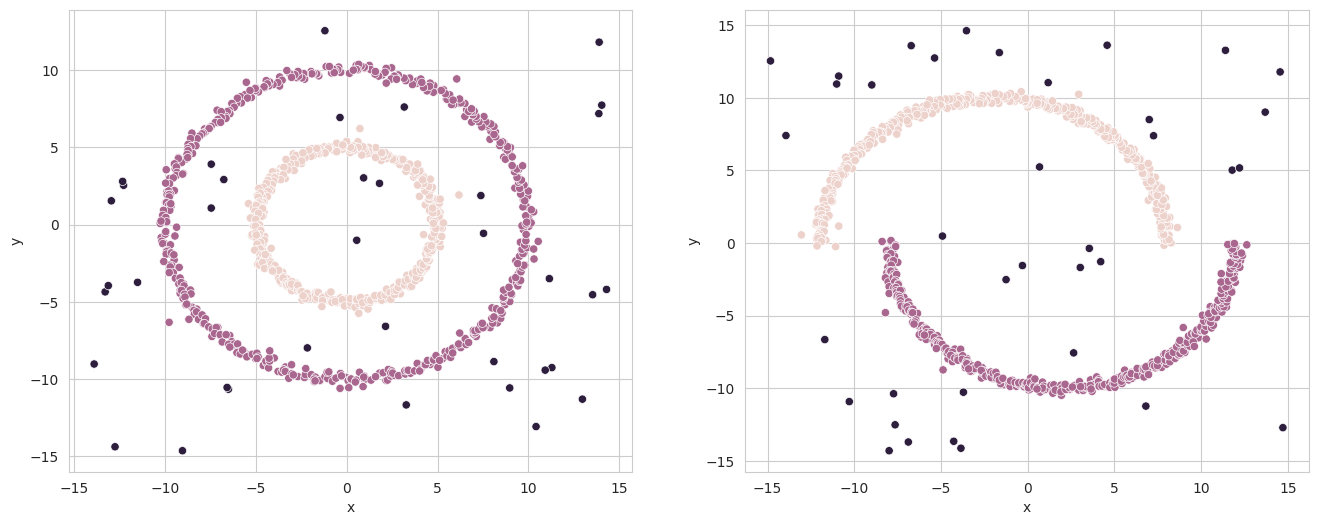

In [9]:
df = pd.DataFrame(np.vstack((x, y, labels)).T, columns=(['x','y','label']))
df2 = pd.DataFrame(np.vstack((x2, y2, labels2)).T, columns=(['x','y','label']))
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
sns.scatterplot(df, x='x', y='y', hue='label',legend=False)
plt.subplot(1,2,2)
sns.scatterplot(df2, x='x', y='y', hue='label',legend=False)
plt.show()